# Hands on timeseries analysis
### part7: Dickey-Fuller test

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.08.18 </div> 
<div style="text-align: right"> Last update: 2020.08.18</div> 

시계열 예측방법인 ARIMA에 대하여 설명한다.
- 참고자료  
    - [Pandas로 하는 시계열 데이터분석](https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=152#sec2)
    - [Time series analysis in Python](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)
    - [A comprehensive beginner’s guide to create a Time Series Forecast](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

### 1. Stationary vs Non-stationary process(time series)  

- Stationary : 데이터의 통계적 성질(mean, variance, covariance 등)이 시간에 독립(시간에 따라 변하지 않음)
- Nonstationary : 통계적 성질이 시간에 따라 변함  

아래의 붉은 색 그래프는 non-stationary이다. 왜냐하면 mean 값이 시간에 따라 증가하기 때문이다.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png" width = 400>

아래의 붉은 색 그래프는 non-stationary이다. 왜냐하면 variance 값이 시간에 따라 증가하기 때문이다.

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png" width = 400>

아래의 붉은 색 그래프는 non-stationary이다. 왜냐하면 covariance 값이 매시간 일정하지 않기 때문이다.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png" width = 400>

Stationarity가 중요한 이유  
- stationary process는 현재 시점에 관측되는 통계지표와 미래의 지표가 일정하므로 예측이 용이하다.  
- 시계열 데이터에 trend나 sesonality 성분이 있으면 그 데이터는 non-stationary이다.  
- 자연계 대부분의 데이터는  non-stationary이다.  
- 대부분의 시계열 분석은 데이터가 stationary라는 가정하에 진행된다.  
- 따라서, 분석하기 전에 raw data를 stationary하게 만든 후 분석 또는 예측모델 설계를 진행한다.  
  (데이터를 완벽하게 stationary로 만들수는 없지만 최대한 근접하게 만든다.)

stationarity를 확인하는 대표적인 방법  
- Plotting rolling statistics : moving average 또는 moving variance를 사용하여 시간에 따라 값들이 변하는지 확인한다.  
- Seasonal decomposition : 데이터를 trend, sesonal, residual 성분으로 분해한다. 시계열을 non-stationary로 만드는 두 요소(trend, seasonality)가 지배적인지 확인한다.
- (Augmented)Dickey-Fuller test  
    - 먼저 데이터가 stationary하지 않다고 가정한다. 
    - 그리고 각각 다른 신뢰 구간에 대해 시험을 실시하고 `Test statistic`과 `Critical values`를 비교한다.  
    - `Test Statistic`가 `Critical Values` 보다 작으면, 앞의 가정이 잘못되었다고 판단한다.  
    - 다시말해 TS가 stationary 하다고 판단한다.[[참고자료]](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)  
    - 상세한 내용은 다음 링크를 참고한다.([[자료1](https://datascienceschool.net/view-notebook/ebb638fc880145b9adeef8dfa630f067/)], [[자료2]](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test))

### 2. stationarity를 확인하는 방법 1 : plotting rolling statistics

`airline passengers.csv` 데이터셋을 사용한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_rows', 500)

from sklearn.metrics import mean_squared_error

In [2]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=['Month'])

In [3]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


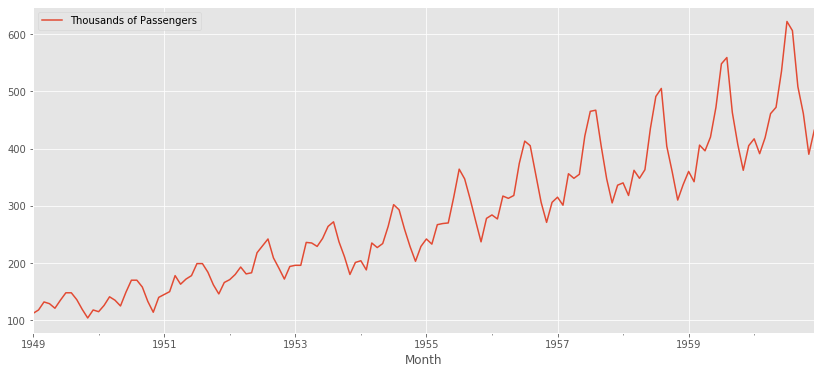

In [4]:
df.plot(figsize = (14, 6))

이동평균과 분산 계산하기

In [5]:
df['MA12'] = df['Thousands of Passengers'].rolling(window=12).mean()
df['MS12'] = df['Thousands of Passengers'].rolling(window = 12).std()

In [6]:
df.head()

,Thousands of Passengers,MA12,MS12
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


차트 그려보기

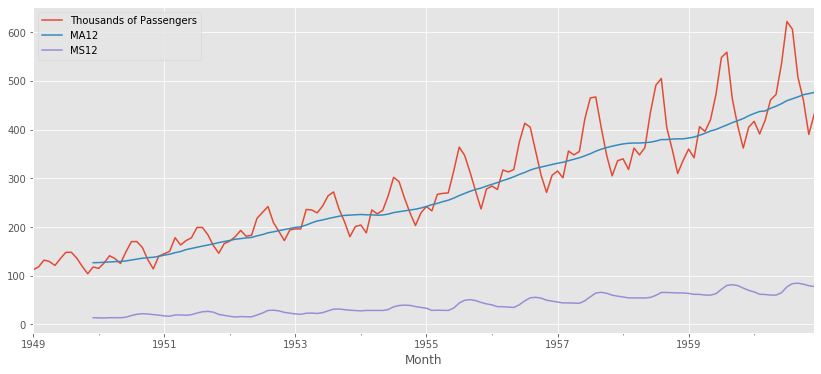

In [7]:
df.plot(figsize = (14, 6))

- variance의 변화는 작지만, mean 값은 증가하는 추세를 보인다.  
- 따라서 non-stationary이다.

In [8]:
df = df.drop(labels = ['MA12', 'MS12'], axis = 1)

### 3. stationarity를 확인하는 방법 2 : seasonal decomposition

4장에서 소개한 `seasonal_decompose`라이브러리를 사용한다.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
def plot_decompose(decomposeresult):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
    decomposeresult.observed.plot(legend=False, color = 'r', ax=ax1)
    ax1.set_ylabel('Observerd')
    decomposeresult.trend.plot(legend=False, color = 'b', ax=ax2)
    ax2.set_ylabel('Trend')
    decomposeresult.seasonal.plot(legend=False, color = 'g', ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposeresult.resid.plot(legend=False, color = 'c', ax=ax4)
    ax4.set_ylabel('Resid')

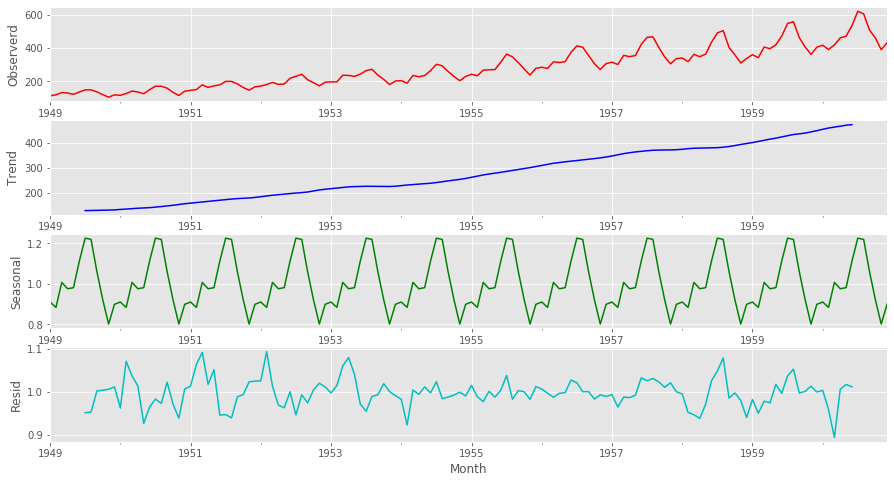

In [11]:
result = seasonal_decompose(df['Thousands of Passengers'], model='multiplicative', freq=12)
plot_decompose(result)

- mean 변화에 영향을 미치는 trend 성분이 크다.  
- variance에 영향을 미치는 seasonal 성분도 있으나 그 크기는 작다.

### 4. stationarity를 확인하는 방법 3 : ADF(Augmented Dickey-Fuller) test

시계열 데이터의 stationary 특성을 확인하기 위해 ADF unit root test를 사용한다.  
- 먼저 데이터가 non-stationary라고 가정한다.(샘플에 unit root가 존재한다고 가정)  
- 결과 값 p-value로 가설의 채택여부를 결정한다.  
    - p-value 값이 작을 때 (≤ 0.05) 가설을 reject 하고 데이터는 **stationary** 함
    - p-value 값이 클 (> 0.05) 가설을 accept 하고 데이터는 **non-stationary** 함

`adfuller` 라이브러리 사용해보기

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
result = adfuller(df['Thousands of Passengers'])

In [14]:
result

(0.815368879206063,
 0.9918802434376413,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

저장된 값을 풀이하면 다음과 같다.  
- test statistic : 시험 결과 값, 0.815368879206063 
- p-value : 0.9918802434376413  
- number of lags : 시험에 사용된 lag 수 13  
- The number of observations used for the ADF regression and calculation of the critical values : 130  
- 각 신뢰구간에서의 critical values : '1%' -3.4816817173418295, '5%' -2.8840418343195267, '10%' -2.578770059171598

`Test Statistic` < `Critical Values` 보다 작으면, 가설(데이터가 non-stationary)이 잘못되었다고 판단한다.  
또는 p-value ≤ 0.05 이면 가설이 잘못되었다고 판단한다.  
- 따라서 위 결과에 따르면 데이터는 non-stationary이다.

테스트 함수 만들기 : 방법1과 방법3 활용

In [15]:
def test_stationarity(df):
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    # 또다른 방법
    # rolmean = pd.rolling_mean(df, window=12)
    
    #시각화
    plt.figure(figsize = (14, 6))
    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print(' ')
    if dftest[1] <= 0.05:
        print('Stationary : p-value {}'.format(dftest[1]))
    else:
        print('Non-Stationary : p-value {}'.format(dftest[1]))

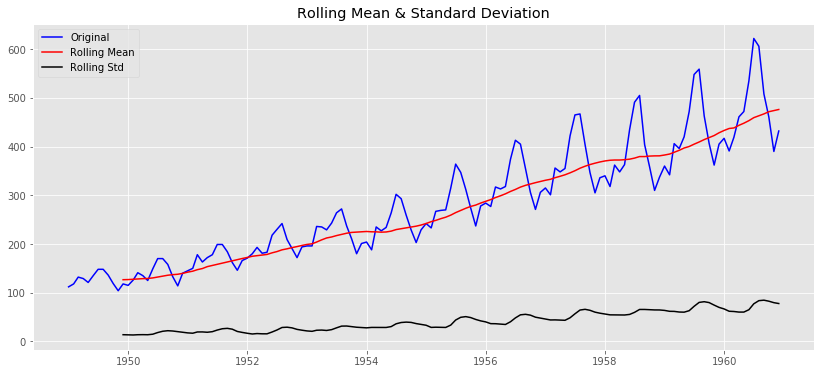

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
 
Non-Stationary : p-value 0.9918802434376413


In [16]:
test_stationarity(df)

### 5. 다른 데이터로 시험해보기

#### 5.1 Monthly milk production

In [17]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/monthly-milk-production.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=True)

In [18]:
df.head()

,pounds per cow
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


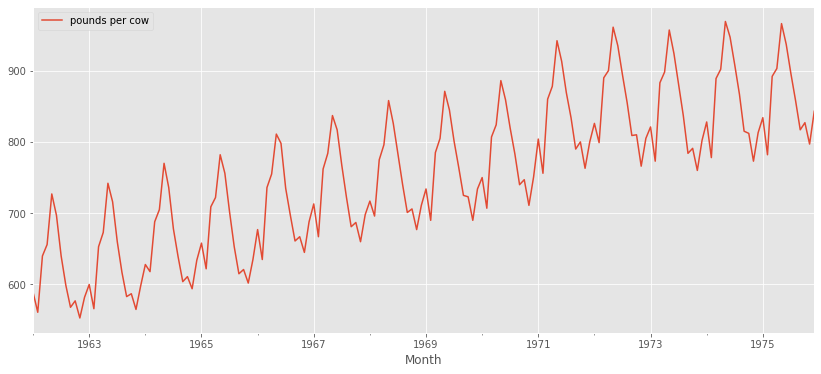

In [19]:
df.plot(figsize = (14, 6))

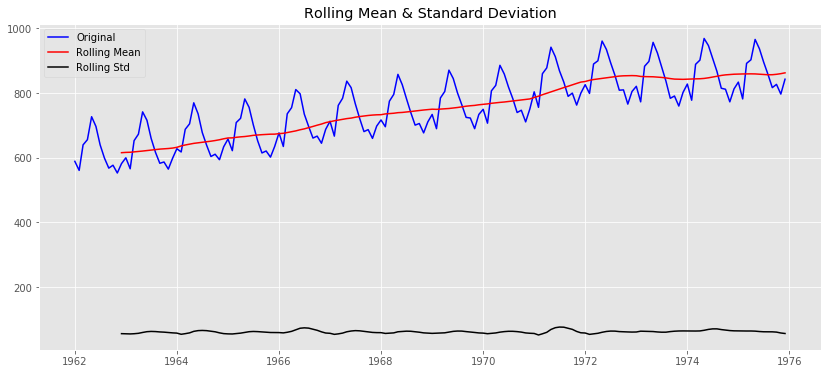

Results of Dickey-Fuller Test:
Test Statistic                  -1.303812
p-value                          0.627427
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64
 
Non-Stationary : p-value 0.6274267086030296


In [20]:
test_stationarity(df)

#### 5.2 Sales of shampoo

In [21]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/sales-of-shampoo.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=True)

In [22]:
df.head()

,Sales of shampoo
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1-01 to 3-12
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales of shampoo  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0+ bytes


parser 함수를 만들어서 데이터를 다시 읽기 : [[출처]](https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=152#sec2)

In [24]:
from datetime import datetime

In [25]:
# Month 칼럼을 읽기 위한 파서
def dateparser(x):
    return datetime.strptime('190'+x, "%Y-%m")
#    "1-01" => "1901-01"

In [26]:
df = pd.read_csv(url, index_col='Month', parse_dates=True, date_parser=dateparser)

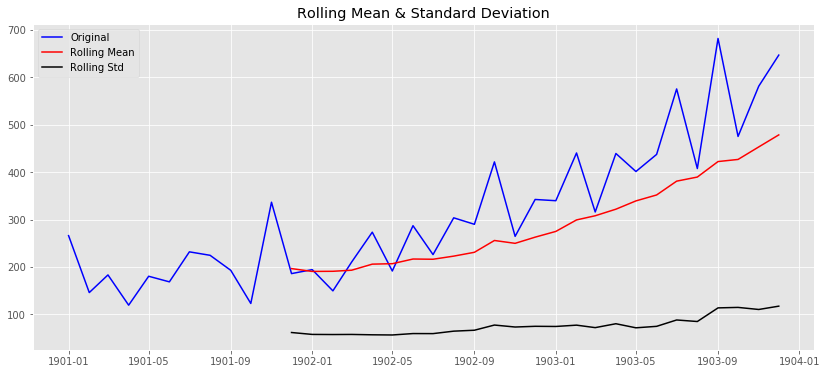

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64
 
Non-Stationary : p-value 1.0


In [27]:
test_stationarity(df)

#### 5.3 airline passengers  
- 여기서는 승객수를 차분(first difference)한 것과 log처리한 결과를 사용해본다.

In [28]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=['Month'])

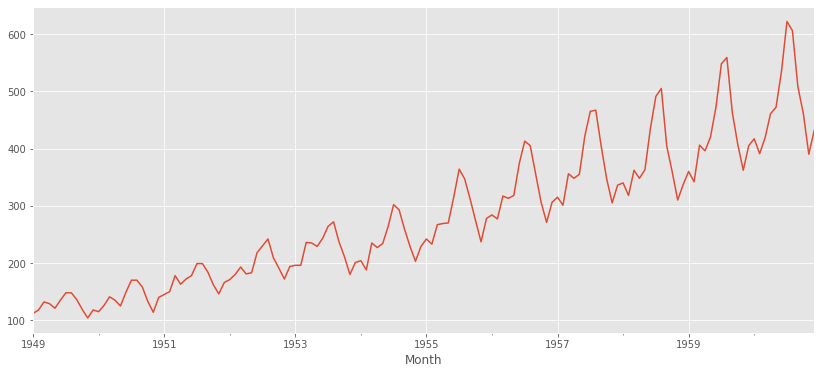

In [29]:
df['Thousands of Passengers'].plot(figsize = (14, 6))

first difference

In [30]:
df['1st_diff'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(1)
# 같은 방법 : df['1st_diff'] = df['Thousands of Passengers'].diff()

In [31]:
df.head()

,Thousands of Passengers,1st_diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


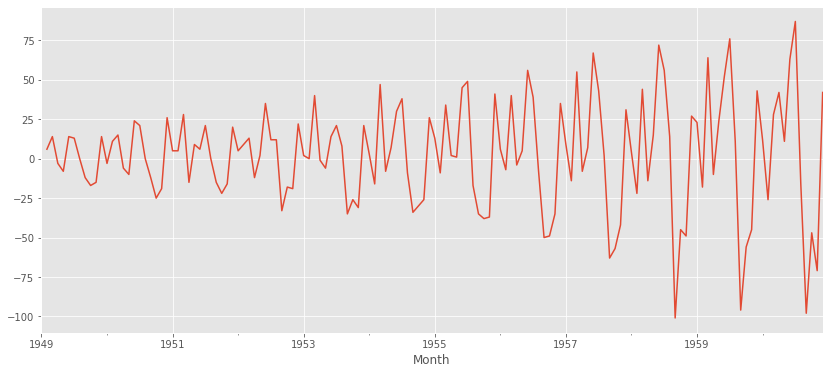

In [32]:
df['1st_diff'].plot(figsize = (14, 6))

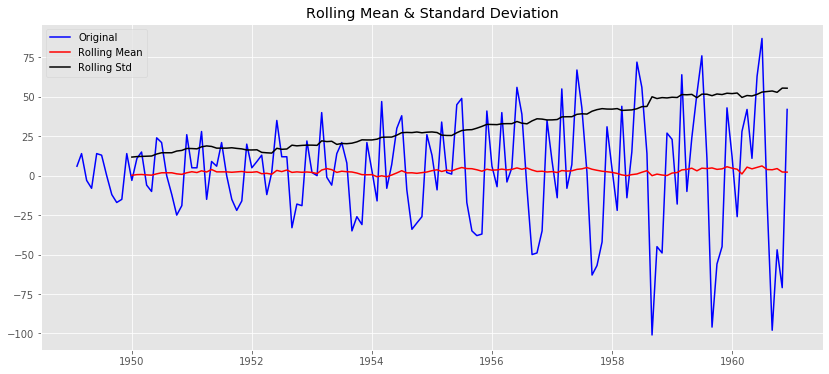

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
 
Non-Stationary : p-value 0.054213290283826786


In [33]:
test_stationarity(df['1st_diff'].dropna())

- 차분연산을 한 결과도 Non-stationary 이지만, p-vlaue가 0.05 근접한 것을 확인할 수 있다.

second difference

In [34]:
df['2nd_diff'] = df['1st_diff'].diff()

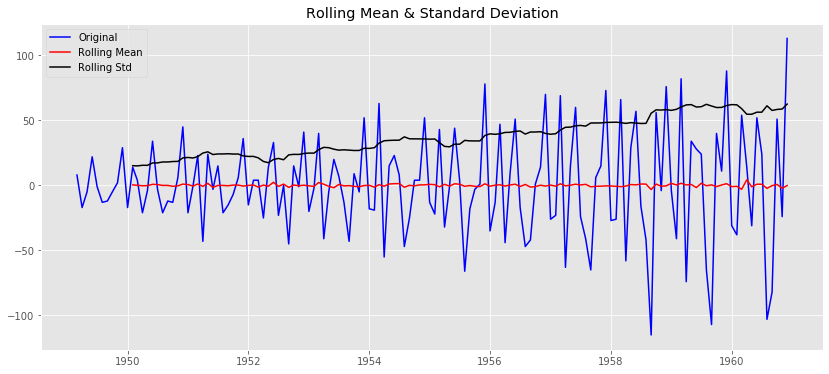

Results of Dickey-Fuller Test:
Test Statistic                -1.638423e+01
p-value                        2.732892e-29
#Lags Used                     1.100000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64
 
Stationary : p-value 2.732891850014397e-29


In [35]:
test_stationarity(df['2nd_diff'].dropna())

- 더 이상 개선되지 않는다.
- trend 성분이 제거되지 않는다.

데이터를 로그 처리한 후 차분을 개산해보기

In [38]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=['Month'])

In [39]:
df_log = np.log(df)

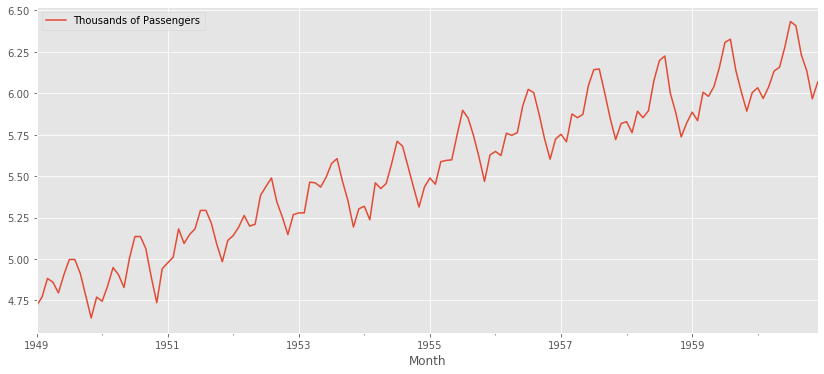

In [40]:
df_log.plot(figsize = (14, 6))

- trend 폭이 크게 감소하였다.

In [41]:
df_log['1st_diff'] = df_log['Thousands of Passengers'].diff()

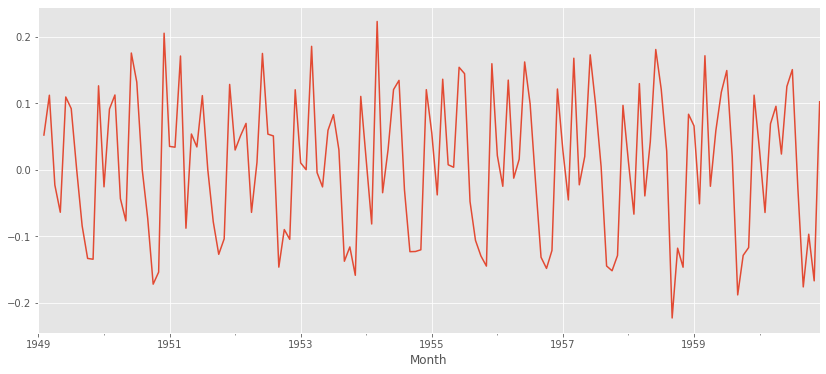

In [42]:
df_log['1st_diff'].plot(figsize = (14, 6))

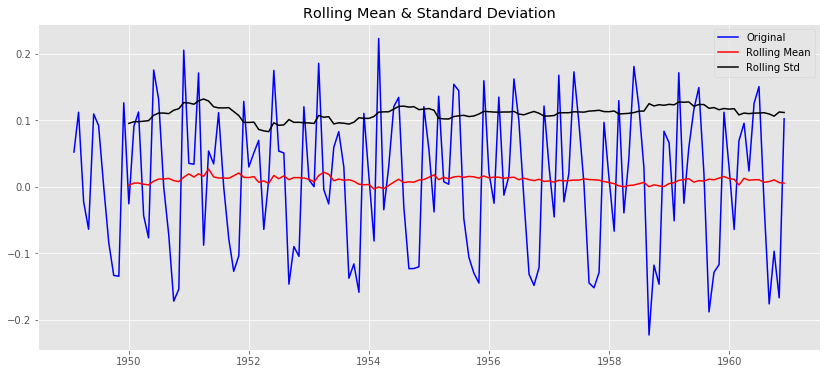

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
 
Non-Stationary : p-value 0.07112054815085295


In [43]:
test_stationarity(df_log['1st_diff'].dropna())

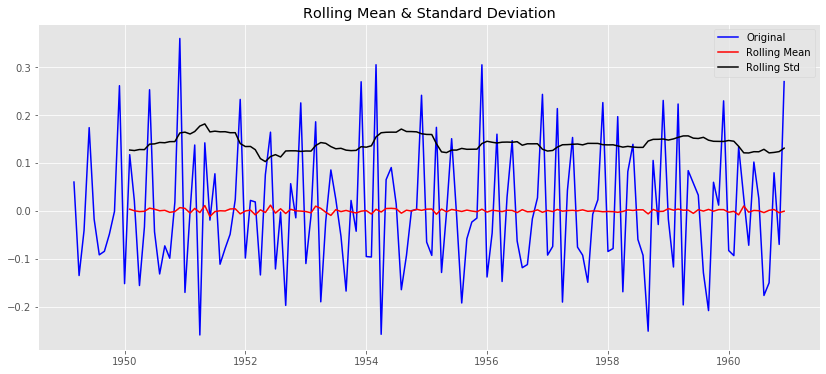

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64
 
Stationary : p-value 7.419304549375568e-13


In [44]:
df_log['2nd_diff'] = df_log['1st_diff'].diff()
test_stationarity(df_log['2nd_diff'].dropna())

- log 처리를 한후, 고차 차분을 실시하여 데이터를 stationary로 만들었다.

In [ ]:
### 6. 정리  
- ADF로 시계열 데이터의 stationary 여부를 확인하는 방법을 설명하였다.  
- 시계열 데이터를 분석할 때 원본 데이터를 stationary에 가깝게 변환한 후 진행한다.  
- 로그변환으로 trend 성분 완화, 차분으로 seasonal 성분을 완화시킬수 있다.